
## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import pickle
from keras import Model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import os

## **Reading Dataset**

In [ ]:
df = pd.read_csv('/content/dataset massive kel 7.csv')

## **Dataset Overview**

In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change%
0,14/06/2024,"3.983,00","3.958,00","3.991,00","3.953,00","0,23K",1.25%
1,13/06/2024,"3.934,00","3.970,00","4.000,00","3.945,00","0,01K",-0.71%
2,12/6/2024,"3.962,00","3.981,00","4.001,00","3.981,00","0,14K",0.79%
3,11/6/2024,"3.931,00","3.930,00","3.975,00","3.892,00","0,19K",0.00%
4,10/6/2024,"3.931,00","3.953,00","3.980,00","3.922,00","0,10K",-0.56%
...,...,...,...,...,...,...,...
1392,8/1/2019,"2.109,00","2.100,00","2.128,00","2.100,00","0,17K",0.81%
1393,7/1/2019,"2.092,00","2.130,00","2.130,00","2.090,00","0,31K",-1.32%
1394,4/1/2019,"2.120,00","2.100,00","2.121,00","2.100,00","0,07K",1.44%
1395,3/1/2019,"2.090,00","2.090,00","2.095,00","2.090,00","0,02K",0.97%


## **Dataset basic information**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1397 non-null   object
 1   Price    1397 non-null   object
 2   Open     1397 non-null   object
 3   High     1397 non-null   object
 4   Low      1397 non-null   object
 5   Vol.     1396 non-null   object
 6   Change%  1397 non-null   object
dtypes: object(7)
memory usage: 76.5+ KB


## **Data Preparation**

In [ ]:
df.drop(['Vol.', 'Change%'], axis=1, inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-31-ba4bc9a812b5>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [ ]:
df.head()

,Date,Price,Open,High,Low
0,2019-01-02,2.070,2.03,2.075,2.03
1,2019-01-03,2.090,2.09,2.095,2.09
2,2019-01-04,2.120,2.10,2.121,2.10
3,2019-01-07,2.092,2.13,2.130,2.09
4,2019-01-08,2.109,2.10,2.128,2.10


In [ ]:
df.duplicated().sum()

63

In [ ]:
df.isnull().sum().sum()

0

# **Visualizing Crude Palm Oil Price History Data**

In [ ]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Palm Oil Historical Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# **Splitting Data to Training & Test Sets**

In [ ]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

272

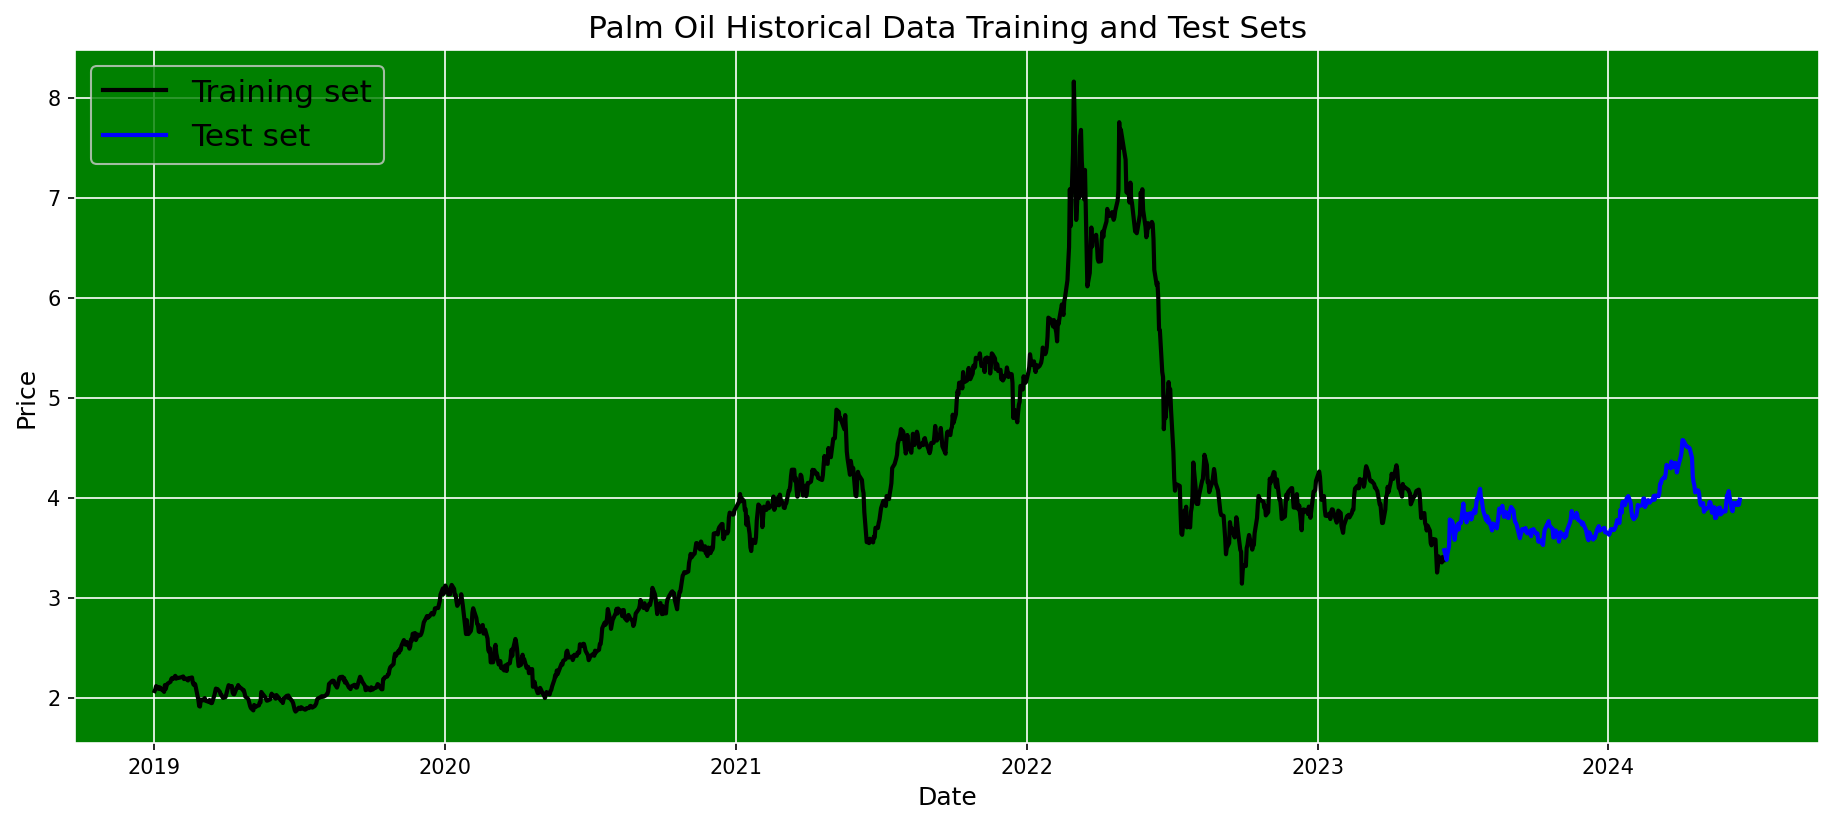

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'green'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Palm Oil Historical Data Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# **Data Scaling**

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# **Restructure Data & Create Sliding Window**

In [ ]:
window_size = 60

In [ ]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [ ]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [ ]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# **Converting Data to Numpy Arrays**

In [ ]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1065, 60, 1)
y_train Shape:  (1065, 1)
X_test Shape:   (272, 60, 1)
y_test Shape:   (272, 1)


# **Creating an LSTM Network**

In [ ]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [ ]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0     

# **Model Evaluation**

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 [==============================] - 2s 50ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00018194019503425807
Test MAPE: 0.03532582221924953
Test Accuracy: 0.9646741777807505


# **Visualizing Results**

In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

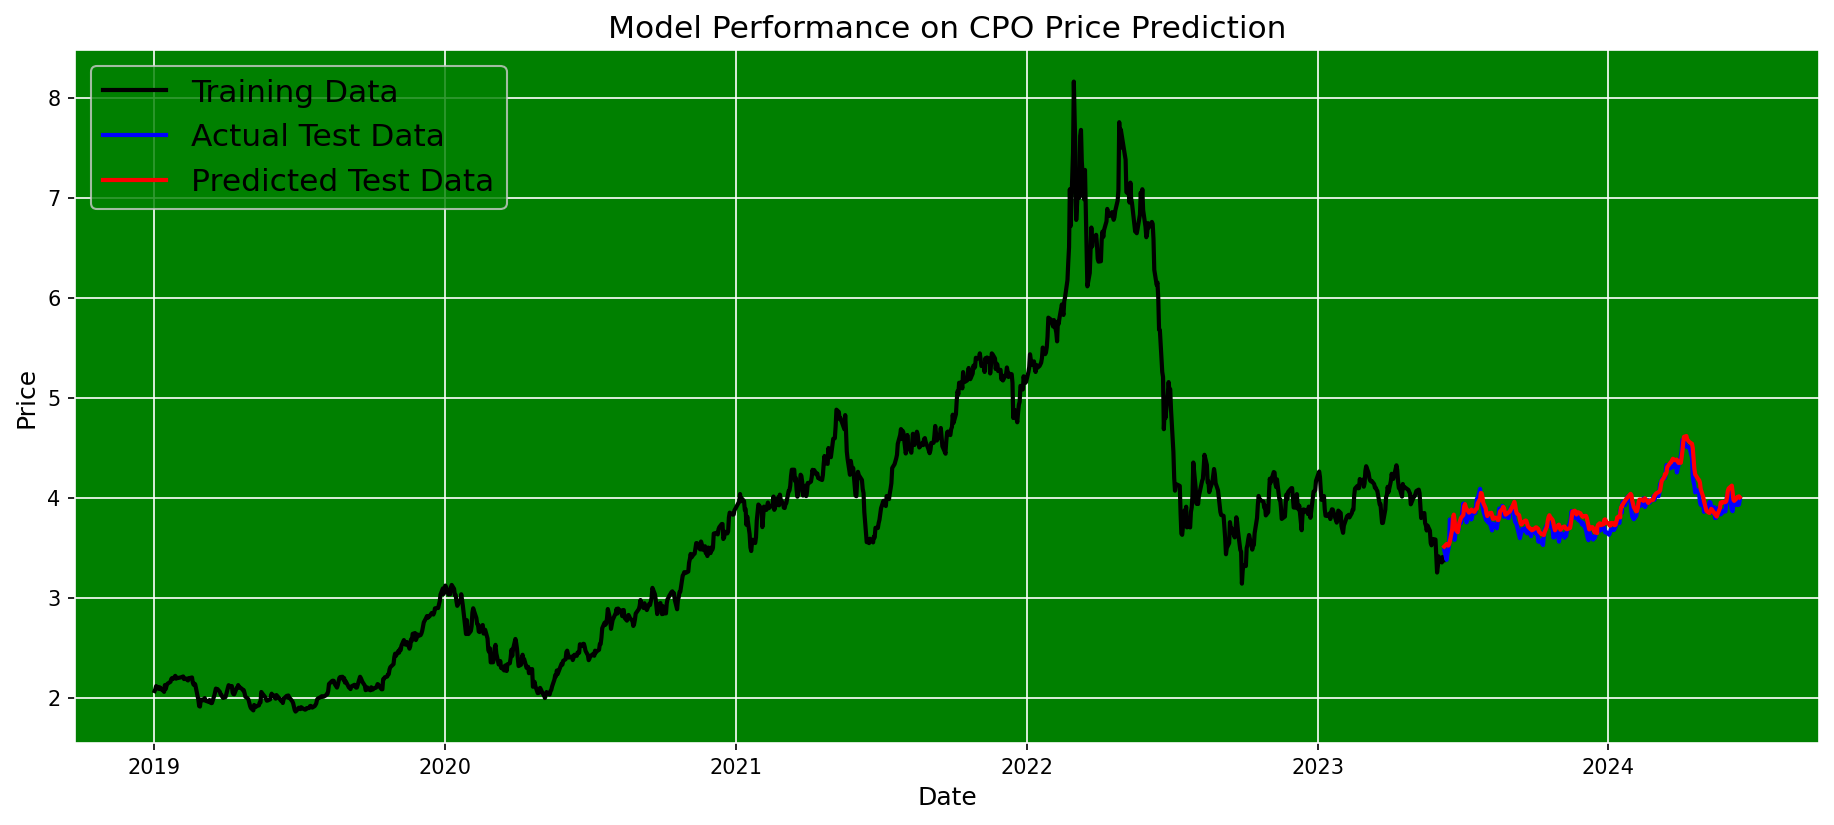

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'green'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on CPO Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [ ]:
import os

model_directory = '/content/gdrive/MyDrive/CPO Price Prediction/Model/'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_path = os.path.join(model_directory, 'CPOPricePrediction.h5')

try:
    model.save(model_path)
    print("Model telah disimpan di:", model_path)
except Exception as e:
    print("Terjadi kesalahan saat menyimpan model:", e)


Model telah disimpan di: /content/gdrive/MyDrive/CPO Price Prediction/Model/CPOPricePrediction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
import os

model_directory = '/content/gdrive/MyDrive/CPO Price Prediction/Model/'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model_path = os.path.join(model_directory, 'CPOPricePrediction.h5')

try:
    model.save(model_path)
    print("Model telah disimpan di:", model_path)
except Exception as e:
    print("Terjadi kesalahan saat menyimpan model:", e)


Model telah disimpan di: /content/gdrive/MyDrive/CPO Price Prediction/Model/CPOPricePrediction.h5
